_Libraries_

In [2]:
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import seaborn as sns


# Defining Functions for Processing Time Series Data

### Formatting Input
We have two types of scraped time series data:
1. Global averages
2. Regional Averages
Here we'll make everything be treated as if it were regional, 'global' just being a region itself. Then we can make the columns and types and names consistent regardless of the data we're reading in.

Note that this data is originally generated in `aoi_calculations.ipynb` and `aoi_extractions.ipynb`.

In [3]:
def format_input(dir: str, file: str, var: str, regional: bool=False, acr: str='GBL'):
    # Read in input data
    input_data = pd.read_csv(os.path.join(dir,file))

    # Global data has a given form
    if not regional:
        input_data['continent'] = acr
        input_data['type'] = acr
        input_data['name'] = acr
        input_data['acronym'] = acr
        input_data.rename(columns = {'ann_agg': 'value'}, inplace=True)
    # IPCC Regional Data has a given form
    else:
        input_data.rename(columns = {
            var.capitalize(): 'value',
            var: 'value',
            'ann_agg': 'value',
            'Ann_agg': 'value',
            'Year': 'year',
            'Esm': 'esm',
            'Experiment': 'experiment',
            'Ensemble': 'ensemble',
            'Variable': 'variable',
            'Continent':'continent',
            'Type':'type',
            'Name':'name',
            'Acronym':'acronym'
        }, inplace=True)

    input_data['year'] = pd.to_datetime(input_data.year, format='%Y')

    # Return the input data which will now have consistent form
    return input_data

Here we show how that function is used. Just give it the path and file name of the data you want to read in, as well as the variable that it contains. Also specify if the data is global, as the input has a different form (hence the need for this function, and the default is to assume it is indeed global data). Here we look at global time series data of annual `tas`.

In [4]:
data_dir = 'extracted_timeseries'
file_name = 'global_tas_allesms_timeseries_2015_2100.csv'
data = format_input(data_dir, file_name, 'tas')
data

,year,value,esm,experiment,ensemble,variable,continent,type,name,acronym
0,1995-01-01,287.436776,CAMS-CSM1-0,historical,r1i1p1f1,tas,GBL,GBL,GBL,GBL
1,1996-01-01,287.502320,CAMS-CSM1-0,historical,r1i1p1f1,tas,GBL,GBL,GBL,GBL
2,1997-01-01,287.612017,CAMS-CSM1-0,historical,r1i1p1f1,tas,GBL,GBL,GBL,GBL
3,1998-01-01,287.661722,CAMS-CSM1-0,historical,r1i1p1f1,tas,GBL,GBL,GBL,GBL
4,1999-01-01,287.526276,CAMS-CSM1-0,historical,r1i1p1f1,tas,GBL,GBL,GBL,GBL
...,...,...,...,...,...,...,...,...,...,...
58962,2095-01-01,290.058673,CanESM5,ssp534-over,r2i1p1f1,tas,GBL,GBL,GBL,GBL
58963,2096-01-01,290.217145,CanESM5,ssp534-over,r2i1p1f1,tas,GBL,GBL,GBL,GBL
58964,2097-01-01,290.335867,CanESM5,ssp534-over,r2i1p1f1,tas,GBL,GBL,GBL,GBL
58965,2098-01-01,290.295876,CanESM5,ssp534-over,r2i1p1f1,tas,GBL,GBL,GBL,GBL


### Function for Summarizing the Data by Groups
In our data are some natural groupings that we would want to summarize the time series over. These are:
* ESM - CanESM5, MIROC6, etc.
* Experiment - SSP119, SSP245, etc.
* Ensemble Member - The r1i1pf1's and the like
* Climate Variable - tas, pr, psl, etc.
* Region - Global, North-West North America, other IPCC regions, etc.

Additionally, we generally want to summarize on smaller time windows than the whole range in the time series. Here we default to summarizing for each of these groups in $20$ year windows. The window 1995-2014 will necessarily be included in this window, as it is the most recent $20$ years in the historical CMIP6 datasets, and is used as the reference period in `STITCHES`.

This function will take as input:
1. The formatted `pd.DataFrame` read in using `format_input()`
2. The function which you want to use to summarize these groupings. These can be existing functions like `np.mean`, or custom made as discussed in just the next section.

In [5]:
def region_summary(input_data: pd.DataFrame, func, **kwargs):
    # Group by model, experiment, ensemble member, year group, region, variable, 20 year chunks
    grouped_data = input_data.groupby([
        'esm', 
        'experiment', 
        'ensemble', 
        'variable', 
        'acronym', 
        pd.cut(input_data.year, pd.date_range('1995', '2100', freq='20YS'), right=False)])
    # Summarize using custom function
    return grouped_data.agg(
        summary_value = pd.NamedAgg(column='value', aggfunc=lambda x: func(x,**kwargs))
    ).reset_index().dropna()

### Custom Summarizing Functions

#### Temperature Threshold Exceeding Counts
This function will return the number of instances that a given model, scenario, ensemble member, exceeded some temperature threshold over the course of a month or year (depending on the resolution of the input data), for each region and $20$ year interval.

In [6]:
def months_above_thresh(x: np.array, thresh: float = 290.):
    if x.empty:
        return None
    else:
        x = x.dropna()
        return np.sum(x > thresh)

### Using the Summarizing Functionality
Below we show how we can use our custom or pre-existing summarizing functions to quickly get the results for our given input dataset, and see how it will be useful to have this pipeline for enabling new summarizations as they are thought up.

#### Number of months above 290°K avg
By ESM, experiment (scenario), ensemble member, and 20-year period

In [7]:
data_summary = region_summary(data, months_above_thresh)
data_summary

,esm,experiment,ensemble,variable,acronym,year,summary_value
0,ACCESS-ESM1-5,historical,r10i1p1f1,tas,GBL,"[1995-01-01, 2015-01-01)",0.0
10,ACCESS-ESM1-5,historical,r11i1p1f1,tas,GBL,"[1995-01-01, 2015-01-01)",0.0
20,ACCESS-ESM1-5,historical,r12i1p1f1,tas,GBL,"[1995-01-01, 2015-01-01)",0.0
30,ACCESS-ESM1-5,historical,r13i1p1f1,tas,GBL,"[1995-01-01, 2015-01-01)",0.0
40,ACCESS-ESM1-5,historical,r14i1p1f1,tas,GBL,"[1995-01-01, 2015-01-01)",0.0
...,...,...,...,...,...,...,...
37204,UKESM1-0-LL,ssp585,r4i1p1f2,tas,GBL,"[2075-01-01, 2095-01-01)",20.0
37246,UKESM1-0-LL,ssp585,r8i1p1f2,tas,GBL,"[2015-01-01, 2035-01-01)",0.0
37247,UKESM1-0-LL,ssp585,r8i1p1f2,tas,GBL,"[2035-01-01, 2055-01-01)",2.0
37248,UKESM1-0-LL,ssp585,r8i1p1f2,tas,GBL,"[2055-01-01, 2075-01-01)",19.0


#### Months above 0.000157 precip flux ($kg/m^2/s$)

In [8]:
data_dir = 'extracted_timeseries'
file_name = 'IPCC_land_regions_pr_MRI-ESM2-0_timeseries_1980_2099.csv'
region_summary(format_input(data_dir, file_name, 'pr', regional=True), months_above_thresh, **{'thresh':0.000157})

,esm,experiment,ensemble,variable,acronym,year,summary_value
0,MRI-ESM2-0,historical,r10i1p1f1,pr,ARP,"[1995-01-01, 2015-01-01)",0.0
5,MRI-ESM2-0,historical,r10i1p1f1,pr,CAF,"[1995-01-01, 2015-01-01)",0.0
10,MRI-ESM2-0,historical,r10i1p1f1,pr,CAR,"[1995-01-01, 2015-01-01)",0.0
15,MRI-ESM2-0,historical,r10i1p1f1,pr,CAU,"[1995-01-01, 2015-01-01)",0.0
20,MRI-ESM2-0,historical,r10i1p1f1,pr,CNA,"[1995-01-01, 2015-01-01)",0.0
...,...,...,...,...,...,...,...
16334,MRI-ESM2-0,ssp585,r5i1p1f1,pr,WSAF,"[2075-01-01, 2095-01-01)",0.0
16336,MRI-ESM2-0,ssp585,r5i1p1f1,pr,WSB,"[2015-01-01, 2035-01-01)",0.0
16337,MRI-ESM2-0,ssp585,r5i1p1f1,pr,WSB,"[2035-01-01, 2055-01-01)",0.0
16338,MRI-ESM2-0,ssp585,r5i1p1f1,pr,WSB,"[2055-01-01, 2075-01-01)",0.0


#### Mean precip flux

In [9]:
region_summary(format_input(data_dir, file_name, 'pr', regional=True), np.mean)

,esm,experiment,ensemble,variable,acronym,year,summary_value
0,MRI-ESM2-0,historical,r10i1p1f1,pr,ARP,"[1995-01-01, 2015-01-01)",0.000003
5,MRI-ESM2-0,historical,r10i1p1f1,pr,CAF,"[1995-01-01, 2015-01-01)",0.000050
10,MRI-ESM2-0,historical,r10i1p1f1,pr,CAR,"[1995-01-01, 2015-01-01)",0.000029
15,MRI-ESM2-0,historical,r10i1p1f1,pr,CAU,"[1995-01-01, 2015-01-01)",0.000009
20,MRI-ESM2-0,historical,r10i1p1f1,pr,CNA,"[1995-01-01, 2015-01-01)",0.000029
...,...,...,...,...,...,...,...
16334,MRI-ESM2-0,ssp585,r5i1p1f1,pr,WSAF,"[2075-01-01, 2095-01-01)",0.000017
16336,MRI-ESM2-0,ssp585,r5i1p1f1,pr,WSB,"[2015-01-01, 2035-01-01)",0.000020
16337,MRI-ESM2-0,ssp585,r5i1p1f1,pr,WSB,"[2035-01-01, 2055-01-01)",0.000020
16338,MRI-ESM2-0,ssp585,r5i1p1f1,pr,WSB,"[2055-01-01, 2075-01-01)",0.000021


# Principal Component Analysis
Here we'll start to explore the idea of reducing the dimension of our metrics. So far we have each of our summary metrics, which are available for each of our IPCC regions, and globally. We'll try to use PCA to extract the most variation using the fewest axis in our dimension space.

## Starting by looking just at mean precipitation in the IPCC regions
We read in the time series files for each ESM


In [10]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_pr_*_timeseries_1980_2099.csv'))]
files

['IPCC_land_regions_pr_MIROC6_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_FGOALS-g3_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_CAMS-CSM1-0_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_MPI-ESM1-2-LR_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_GFDL-ESM4_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_MRI-ESM2-0_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_CESM2-WACCM_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_UKESM1-0-LL_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_MPI-ESM1-2-HR_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_IPSL-CM6A-LR_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_CanESM5_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_ACCESS-ESM1-5_timeseries_1980_2099.csv']

And use our formatting and summarizing functions to read in our data, and get the mean prcip flux in each of our groups.

In [11]:
full_data = pd.concat([region_summary(format_input(data_dir, file, 'pr', regional=True), np.mean) for file in files])
full_data

,esm,experiment,ensemble,variable,acronym,year,summary_value
0,MIROC6,historical,r10i1p1f1,pr,ARP,"[1995-01-01, 2015-01-01)",0.000004
5,MIROC6,historical,r10i1p1f1,pr,CAF,"[1995-01-01, 2015-01-01)",0.000054
10,MIROC6,historical,r10i1p1f1,pr,CAR,"[1995-01-01, 2015-01-01)",0.000026
15,MIROC6,historical,r10i1p1f1,pr,CAU,"[1995-01-01, 2015-01-01)",0.000019
20,MIROC6,historical,r10i1p1f1,pr,CNA,"[1995-01-01, 2015-01-01)",0.000029
...,...,...,...,...,...,...,...
42994,ACCESS-ESM1-5,ssp585,r9i1p1f1,pr,WSAF,"[2075-01-01, 2095-01-01)",0.000018
42996,ACCESS-ESM1-5,ssp585,r9i1p1f1,pr,WSB,"[2015-01-01, 2035-01-01)",0.000019
42997,ACCESS-ESM1-5,ssp585,r9i1p1f1,pr,WSB,"[2035-01-01, 2055-01-01)",0.000020
42998,ACCESS-ESM1-5,ssp585,r9i1p1f1,pr,WSB,"[2055-01-01, 2075-01-01)",0.000019


Spread the data so that each region becomes the variable and the flux is the value for each region at each observation.

In [12]:
full_wide = full_data[full_data.year == full_data.year.values[-1]].\
    rename(columns={'summary_value': 'mean_pr'}).\
        pivot_table('mean_pr', ['esm', 'experiment', 'ensemble', 'variable', 'year'], 'acronym')
full_wide

acronym                                                                    ARP  \
esm           experiment ensemble  variable year                                 
ACCESS-ESM1-5 ssp126     r10i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000003   
                         r11i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000003   
                         r12i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000003   
                         r13i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000003   
                         r14i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000003   
...                                                                        ...   
UKESM1-0-LL   ssp585     r1i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000002   
                         r2i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000002   
                         r3i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000002   
                         r4i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000002   
                         r8i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000002   

acronym                                                                    CAF  \
esm           experiment ensemble  variable year                                 
ACCESS-ESM1-5 ssp126     r10i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000056   
                         r11i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000057   
                         r12i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000056   
                         r13i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000057   
                         r14i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000056   
...                                                                        ...   
UKESM1-0-LL   ssp585     r1i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000046   
                         r2i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000047   
                         r3i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000047   
                         r4i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000047   
                         r8i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000046   

acronym                                                                    CAR  \
esm           experiment ensemble  variable year                                 
ACCESS-ESM1-5 ssp126     r10i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000022   
                         r11i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000021   
                         r12i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000022   
                         r13i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000024   
                         r14i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000023   
...                                                                        ...   
UKESM1-0-LL   ssp585     r1i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000021   
                         r2i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000021   
                         r3i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000019   
                         r4i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000022   
                         r8i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000021   

acronym                                                                    CAU  \
esm           experiment ensemble  variable year                                 
ACCESS-ESM1-5 ssp126     r10i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000011   
                         r11i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000011   
                         r12i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000010   
                         r13i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000012   
                         r14i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000010   
...                                                                        ...   
UKESM1-0-LL   ssp585     r1i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000010   
                         r2i1p1f2  pr       [2075-01-01, 2095

### Load the `sklearn` functionality for PCA

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Running PCA
Scale the data then run PCA with max number of components output since quick to run.

We plot the ratio variance explained by each component to get a sense of how many we should use. There are a couple of _"shoulders"_, but probably 3-6 components is pretty good. 70\% of variance explained by PC3 and 90\% by PC6.

We see clear clustering of both ESMs and scenarios when plotting PC1 and PC2. Still when plotting with PC3 and PC4 but a bit less separation for sure. PC9 vs PC10 is plotted in the one figure as well as demonstration of loss of returns with extra components.

PC1 appears to be capturing a bit of both difference in model and scenario behavior. Clearly ACCESS-ESM1-5 and the two, FGOALS-g3 and CAMS-CSM1-0 are separated from the rest of the pack, while the remaining models on average seem to score not all too different, though definitely with varying spreads. But we see that there is a clear delineation in scenarios along PC1 as these are split along the horizontal axis. The spread in the central models seems to do with their sensitivity to scenarios in a way.

The regions that inform PC1 are not entirely intuitive as a grouping, though we do see that the very northern regions are important. 

Meanwhile, PC2 clearly is separating the ESMs but not the scenarios at all.

* PC1
    * Most northern regions most important to this component, though do not completely dominate in any sense of the word. Lots of regions with relatively comparable weighting
        * In general we will see that the region groupings for each component are not super intuitive
    * Clearly distinguishing scenarios
    * Distinguished a few ESMs from the rest
    * Remaining ESMs have varying spreads, perhaps hinting at their level of sensitivity to scenario in the northern regions
* PC2
    * Targeting ESMs clearly, and not at all scenarios
    * Again no clear region winner but def oceania, india, north and south South America are strong players
* PC3
    * The Biggest thing is separating CanESM5, with some other lesser model separation.
    * No real scenario separation
* PC9 and PC10
    * Just shown as demonstration for diminishing returns

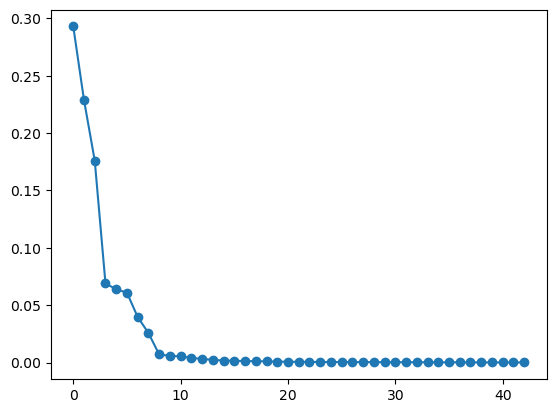

In [14]:
scaler = StandardScaler()
scaler.fit(full_wide)
fw_scaled = scaler.transform(full_wide)  
pca = PCA()
full_pca = pca.fit_transform(fw_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.scatter(x=range(pca.n_components_), y=pca.explained_variance_ratio_)
plt.show()
plt.close()

#### Plotting the first two components
ESMs clearly clustered using first two principal components.

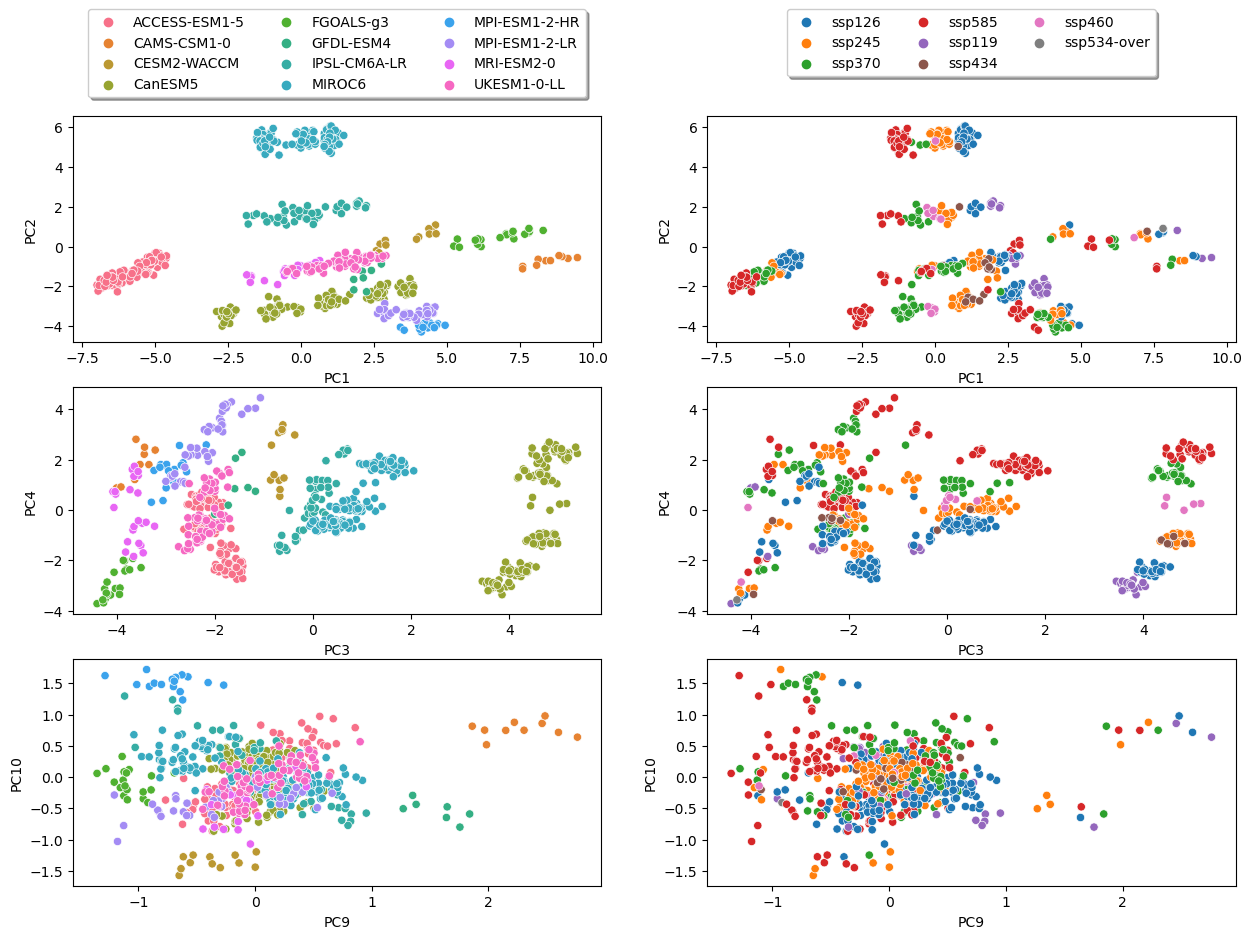

In [15]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))

sns.scatterplot(ax=ax1, x=full_pca[:,0], y=full_pca[:,1], hue=[full_wide.index[i][0] for i in range(full_wide.shape[0])])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
           ncol=3, fancybox=True, shadow=True)
ax1.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax2, x=full_pca[:,0], y=full_pca[:,1], hue=[full_wide.index[i][1] for i in range(full_wide.shape[0])])
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
           ncol=3, fancybox=True, shadow=True)
ax2.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax3, x=full_pca[:,2], y=full_pca[:,3], hue=[full_wide.index[i][0] for i in range(full_wide.shape[0])])
ax3.legend_ = None
ax3.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax4, x=full_pca[:,2], y=full_pca[:,3], hue=[full_wide.index[i][1] for i in range(full_wide.shape[0])])
ax4.legend_ = None
ax4.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax5, x=full_pca[:,8], y=full_pca[:,9], hue=[full_wide.index[i][0] for i in range(full_wide.shape[0])])
ax5.legend_ = None
ax5.set(xlabel="PC{}".format(9), ylabel="PC{}".format(10))

sns.scatterplot(ax=ax6, x=full_pca[:,8], y=full_pca[:,9], hue=[full_wide.index[i][1] for i in range(full_wide.shape[0])])
ax6.legend_ = None
ax6.set(xlabel="PC{}".format(9), ylabel="PC{}".format(10))

plt.show()
plt.close()

#### Components 3 & 4
ESMs still quite clustered, but less so, for sure.

#### Function for plotting components with weight vectors

In [16]:
def myplot(score,coeff,cutoffone,cutofftwo,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    sns.scatterplot(x=xs * scalex,y=ys * scaley, hue = [full_wide.index[i][0] for i in range(full_wide.shape[0])])
    #plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        if (np.abs(coeff[i,0]) >= cutoffone) or (np.abs(coeff[i,1]) >= cutofftwo):
            plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
            if labels is None:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, full_wide.columns.values[i], color = 'g', ha = 'center', va = 'center')
            else:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
#plt.grid()
plt.close()

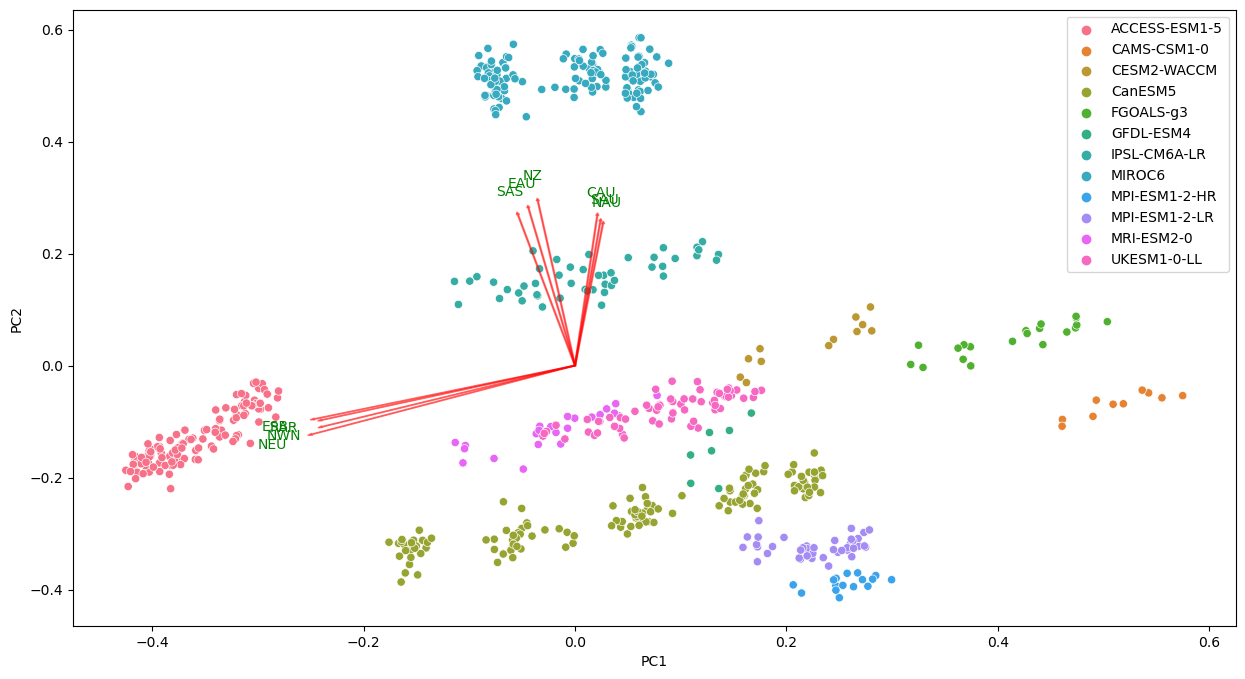

In [17]:
# First Component, mean precipitation in Siberia, North East Russia, North West North America
# Second Component, mean precipitation in Australia and South Asia
plt.figure(figsize=(15,8))
myplot(full_pca[:,0:2],np.transpose(pca.components_[0:2, :]),0.23,0.25)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.show()
plt.close()

For third and fourth components, interpretation even more so not as clear. Can see the regions of course, but the groupings aren't particular intuitive.

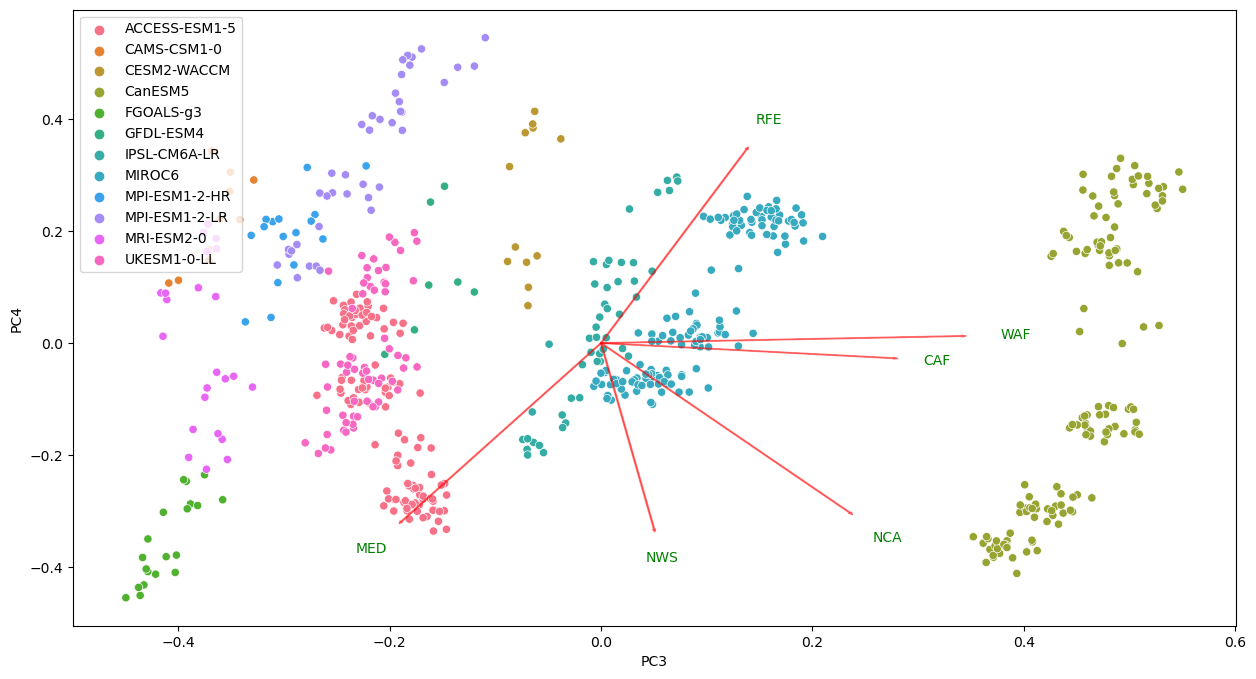

In [18]:
# First Component, mean precipitation in Central/Western Africa
# Second Component, mean precipitation in Australia and South Asia
plt.figure(figsize=(15,8))
myplot(full_pca[:,2:4],np.transpose(pca.components_[2:4, :]),0.25,0.25)
plt.xlabel("PC{}".format(3))
plt.ylabel("PC{}".format(4))
plt.show()
plt.close()

### Looking at Components by Region

In [19]:
import geopandas as gpd

#### Preparing data

In [20]:
# Load in data
url = 'IPCC-WGI-reference-regions-v4_shapefile.zip'
land_main_gdf = gpd.read_file(url)
IPCC_names  = land_main_gdf['Acronym'].unique()

In [21]:
pc_df = pd.DataFrame({
    'region': full_wide.columns.values,
    'PC1': np.transpose(pca.components_[0, :]),
    'PC2': np.transpose(pca.components_[1, :]),
    'PC3': np.transpose(pca.components_[2, :]),
    'PC4': np.transpose(pca.components_[3, :])
})
region_names = pd.DataFrame({
    'Name': land_main_gdf.Name.values,
    'Acronym': land_main_gdf.Acronym.values
})
pc_df_named = pd.merge(region_names, pc_df, left_on='Acronym', right_on='region', how='right')

In [22]:
pc_df = pd.DataFrame({
    'region': full_wide.columns.values,
    'PC1': np.transpose(pca.components_[0, :]),
    'PC2': np.transpose(pca.components_[1, :]),
    'PC3': np.transpose(pca.components_[2, :]),
    'PC4': np.transpose(pca.components_[3, :])
})
pc_df
land_data = pd.merge(land_main_gdf, pc_df, left_on='Acronym', right_on='region', how='inner')

Here, since each of our variables is mean precip flux, just for a different region, we can look at the coefficient of each region by principal component. This should help in interpretation, perhaps better than the vectors on the plots above.

We can see which regions are weighted heavily in each principal component.

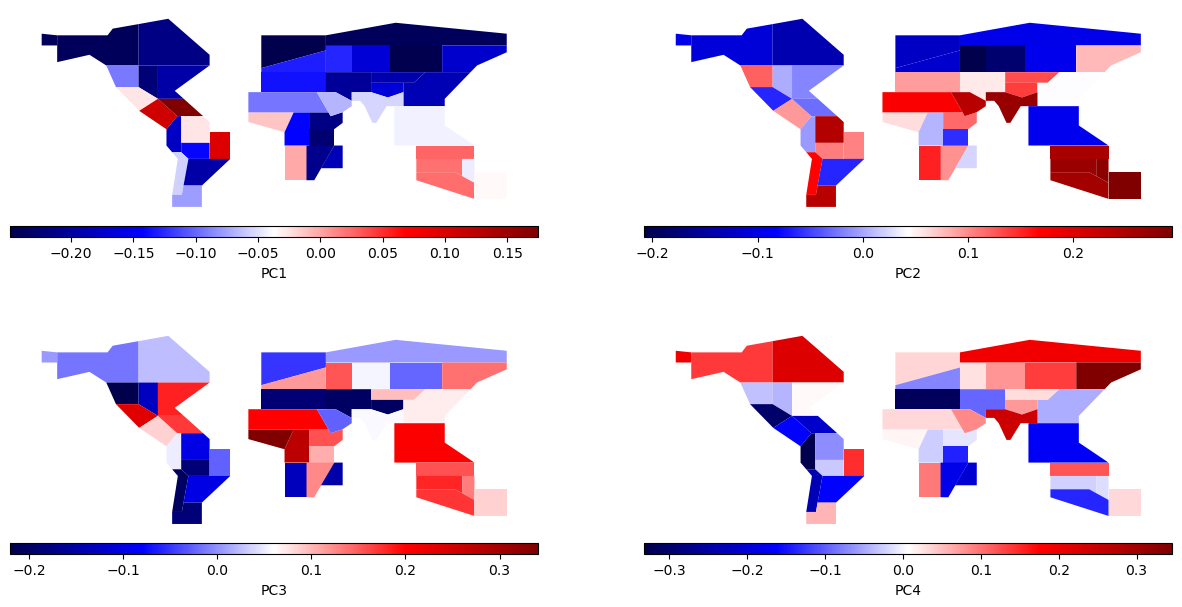

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
vmin = -0.25
vmax = 0.25

# Optional grey out small weighted regions
# land_data.loc[np.abs(land_data['PC1']) < 0.1, 'PC1'] = np.nan
# land_data.loc[np.abs(land_data['PC2']) < 0.15, 'PC2'] = np.nan
# land_data.loc[np.abs(land_data['PC3']) < 0.2, 'PC3'] = np.nan
# land_data.loc[np.abs(land_data['PC4']) < 0.2, 'PC4'] = np.nan


component = 'PC1'
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
ax1.set_axis_off()
#land_data.loc[np.abs(land_data['PC1']) < 0.1] = np.nan
land_data.plot(ax=ax1, column=component, cmap='seismic', legend=True, cax=cax1,
    legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
ax2.set_axis_off()
land_data.plot(ax=ax2, column=component, cmap='seismic', legend=True, cax=cax2,
    legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC3'
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("bottom", size="5%", pad=0.1)
ax3.set_axis_off()
land_data.plot(ax=ax3, column=component, cmap='seismic', legend=True, cax=cax3,
    legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("bottom", size="5%", pad=0.1)
ax4.set_axis_off()
land_data.plot(ax=ax4, column=component, cmap='seismic', legend=True, cax=cax4,
    legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=-0.3)

plt.show()
plt.close()

# PCA tas

In [81]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_tas_*_timeseries_1980_2099.csv'))]
regional_data = pd.concat([region_summary(format_input(data_dir, file, 'tas', regional=True), np.mean) for file in files])

In [82]:
full_data = pd.concat([regional_data])
full_data

,esm,experiment,ensemble,variable,acronym,year,summary_value
0,ACCESS-ESM1-5,historical,r10i1p1f1,tas,ARP,"[1995-01-01, 2015-01-01)",296.733598
5,ACCESS-ESM1-5,historical,r10i1p1f1,tas,CAF,"[1995-01-01, 2015-01-01)",299.770269
10,ACCESS-ESM1-5,historical,r10i1p1f1,tas,CAR,"[1995-01-01, 2015-01-01)",300.028126
15,ACCESS-ESM1-5,historical,r10i1p1f1,tas,CAU,"[1995-01-01, 2015-01-01)",297.284557
20,ACCESS-ESM1-5,historical,r10i1p1f1,tas,CNA,"[1995-01-01, 2015-01-01)",287.639627
...,...,...,...,...,...,...,...
3434,GFDL-ESM4,ssp585,r1i1p1f1,tas,WSAF,"[2075-01-01, 2095-01-01)",296.583726
3436,GFDL-ESM4,ssp585,r1i1p1f1,tas,WSB,"[2015-01-01, 2035-01-01)",275.974654
3437,GFDL-ESM4,ssp585,r1i1p1f1,tas,WSB,"[2035-01-01, 2055-01-01)",276.998721
3438,GFDL-ESM4,ssp585,r1i1p1f1,tas,WSB,"[2055-01-01, 2075-01-01)",278.181250


In [83]:
full_wide = full_data[full_data.year == full_data.year.values[-1]].\
    rename(columns={'summary_value': 'mean_tas'}).\
        pivot_table('mean_tas', ['esm', 'experiment', 'ensemble', 'variable', 'year'], 'acronym').dropna()
full_wide

acronym                                                                      ARP  \
esm           experiment ensemble  variable year                                   
ACCESS-ESM1-5 ssp126     r10i1p1f1 tas      [2075-01-01, 2095-01-01)  298.933728   
                         r11i1p1f1 tas      [2075-01-01, 2095-01-01)  298.918643   
                         r12i1p1f1 tas      [2075-01-01, 2095-01-01)  298.970906   
                         r13i1p1f1 tas      [2075-01-01, 2095-01-01)  298.964493   
                         r14i1p1f1 tas      [2075-01-01, 2095-01-01)  298.998965   
...                                                                          ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas      [2075-01-01, 2095-01-01)  305.069895   
                         r2i1p1f2  tas      [2075-01-01, 2095-01-01)  305.191209   
                         r3i1p1f2  tas      [2075-01-01, 2095-01-01)  305.250036   
                         r4i1p1f2  tas      [2075-01-01, 2095-01-01)  305.376205   
                         r8i1p1f2  tas      [2075-01-01, 2095-01-01)  305.208554   

acronym                                                                      CAF  \
esm           experiment ensemble  variable year                                   
ACCESS-ESM1-5 ssp126     r10i1p1f1 tas      [2075-01-01, 2095-01-01)  301.375324   
                         r11i1p1f1 tas      [2075-01-01, 2095-01-01)  301.240157   
                         r12i1p1f1 tas      [2075-01-01, 2095-01-01)  301.290979   
                         r13i1p1f1 tas      [2075-01-01, 2095-01-01)  301.307998   
                         r14i1p1f1 tas      [2075-01-01, 2095-01-01)  301.355898   
...                                                                          ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas      [2075-01-01, 2095-01-01)  305.784363   
                         r2i1p1f2  tas      [2075-01-01, 2095-01-01)  305.842867   
                         r3i1p1f2  tas      [2075-01-01, 2095-01-01)  305.891779   
                         r4i1p1f2  tas      [2075-01-01, 2095-01-01)  305.857653   
                         r8i1p1f2  tas      [2075-01-01, 2095-01-01)  305.770646   

acronym                                                                      CAR  \
esm           experiment ensemble  variable year                                   
ACCESS-ESM1-5 ssp126     r10i1p1f1 tas      [2075-01-01, 2095-01-01)  301.276503   
                         r11i1p1f1 tas      [2075-01-01, 2095-01-01)  301.276722   
                         r12i1p1f1 tas      [2075-01-01, 2095-01-01)  301.396007   
                         r13i1p1f1 tas      [2075-01-01, 2095-01-01)  301.351326   
                         r14i1p1f1 tas      [2075-01-01, 2095-01-01)  301.350612   
...                                                                          ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas      [2075-01-01, 2095-01-01)  303.797040   
                         r2i1p1f2  tas      [2075-01-01, 2095-01-01)  303.698394   
                         r3i1p1f2  tas      [2075-01-01, 2095-01-01)  303.674989   
                         r4i1p1f2  tas      [2075-01-01, 2095-01-01)  303.852812   
                         r8i1p1f2  tas      [2075-01-01, 2095-01-01)  303.674472   

acronym                                                                      CAU  \
esm           experiment ensemble  variable year                                   
ACCESS-ESM1-5 ssp126     r10i1p1f1 tas      [2075-01-01, 2095-01-01)  298.789126   
                         r11i1p1f1 tas      [2075-01-01, 2095-01-01)  298.646378   
                         r12i1p1f1 tas      [2075-01-01, 2095-01-01)  298.703391   
                         r13i1p1f1 tas      [2075-01-01, 2095-01-01)  298.756075   
                         r14i1p1f1 tas      [2075-01-01, 2095-01-01)  298.695519   
...                                                                          ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas      [2075

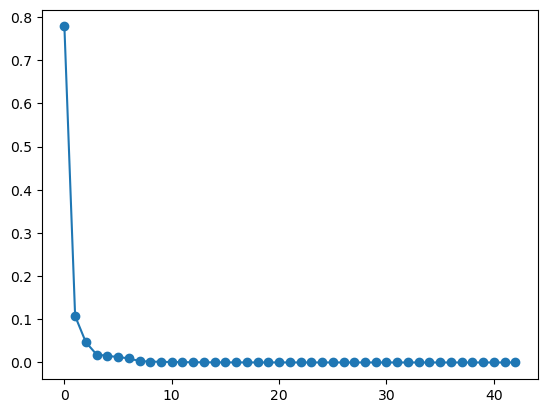

In [84]:
scaler = StandardScaler()
scaler.fit(full_wide)
fw_scaled = scaler.transform(full_wide)  
pca = PCA()
full_pca = pca.fit_transform(fw_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.scatter(x=range(pca.n_components_), y=pca.explained_variance_ratio_)
plt.show()
plt.close()

For mean temp PCA, first component seems to separate scenarios, and second component separates the models. The Third and fourth components again cluster models, but do little to differentiate scenarios within.

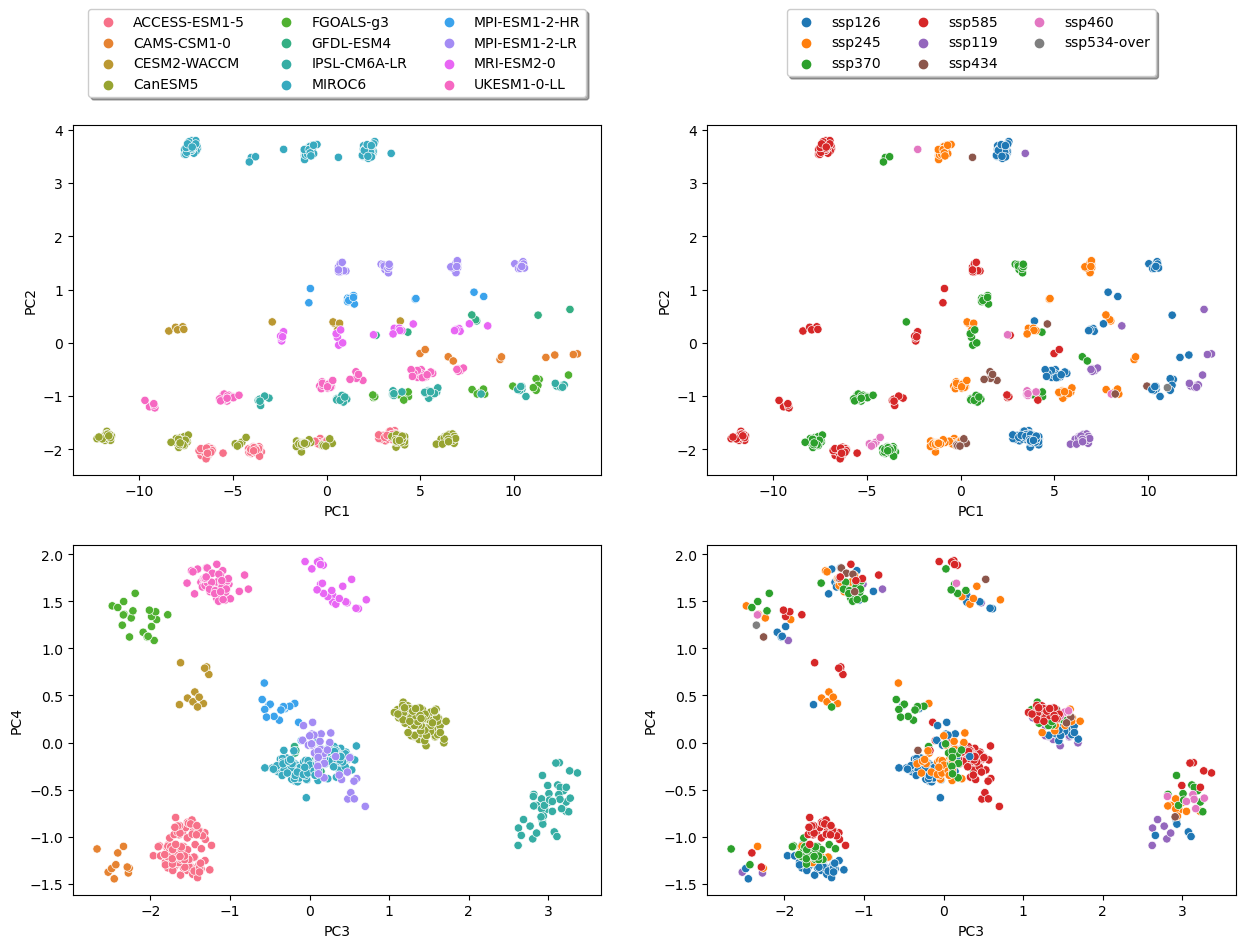

In [86]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))

sns.scatterplot(ax=ax1, x=full_pca[:,0], y=full_pca[:,1], hue=[full_wide.index[i][0] for i in range(full_wide.shape[0])])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
               ncol=3, fancybox=True, shadow=True)
ax1.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax2, x=full_pca[:,0], y=full_pca[:,1], hue=[full_wide.index[i][1] for i in range(full_wide.shape[0])])
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
               ncol=3, fancybox=True, shadow=True)
ax2.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax3, x=full_pca[:,2], y=full_pca[:,3], hue=[full_wide.index[i][0] for i in range(full_wide.shape[0])])
ax3.legend_ = None
ax3.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax4, x=full_pca[:,2], y=full_pca[:,3], hue=[full_wide.index[i][1] for i in range(full_wide.shape[0])])
ax4.legend_ = None
ax4.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

plt.show()
plt.close()

First component is a wholistic view. Each region (including global and conus) have similar weight. The other components focus on specific regions seen below.

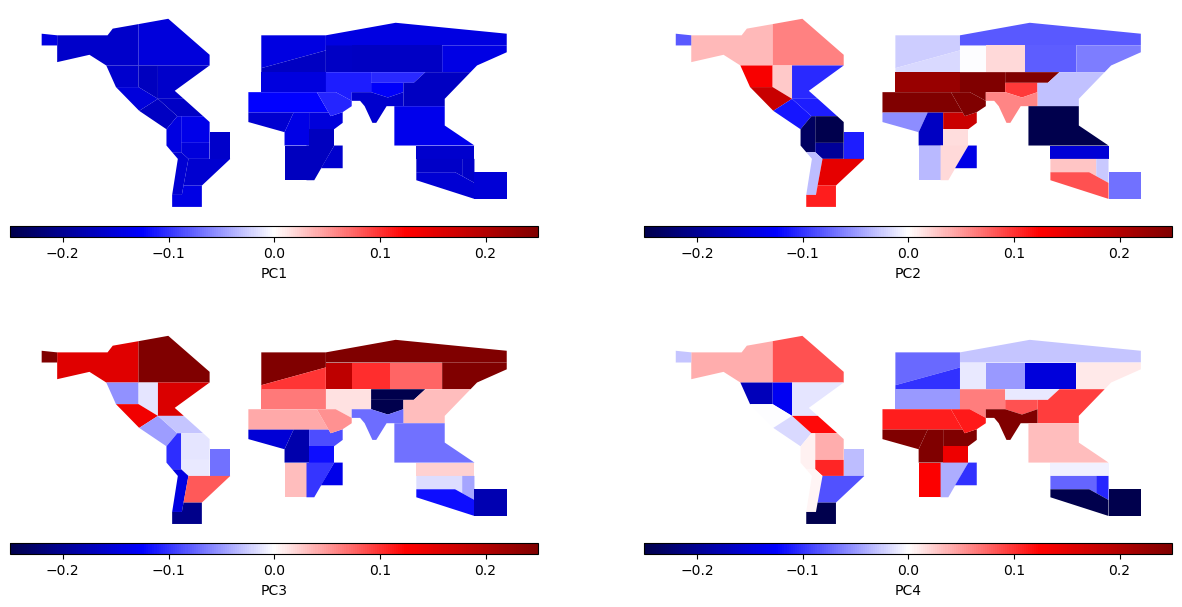

In [29]:
pc_df = pd.DataFrame({
    'region': full_wide.columns.values,
    'PC1': np.transpose(pca.components_[0, :]),
    'PC2': np.transpose(pca.components_[1, :]),
    'PC3': np.transpose(pca.components_[2, :]),
    'PC4': np.transpose(pca.components_[3, :])
})
land_data = pd.merge(land_main_gdf, pc_df, left_on='Acronym', right_on='region', how='inner')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
vmin = -0.25
vmax = 0.25

# Optional grey out small weighted regions
# land_data.loc[np.abs(land_data['PC1']) < 0.2, 'PC1'] = np.nan
# land_data.loc[np.abs(land_data['PC2']) < 0.2, 'PC2'] = np.nan
# land_data.loc[np.abs(land_data['PC3']) < 0.2, 'PC3'] = np.nan
# land_data.loc[np.abs(land_data['PC4']) < 0.2, 'PC4'] = np.nan


component = 'PC1'
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
ax1.set_axis_off()
land_data.plot(ax=ax1, column=component, cmap='seismic', legend=True, cax=cax1,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
ax2.set_axis_off()
land_data.plot(ax=ax2, column=component, cmap='seismic', legend=True, cax=cax2,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC3'
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("bottom", size="5%", pad=0.1)
ax3.set_axis_off()
land_data.plot(ax=ax3, column=component, cmap='seismic', legend=True, cax=cax3,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("bottom", size="5%", pad=0.1)
ax4.set_axis_off()
land_data.plot(ax=ax4, column=component, cmap='seismic', legend=True, cax=cax4,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=-0.3)

plt.show()
plt.close()

# General PCA

In [30]:
def my_pca(wide_data):
    # Do PCA
    scaler = StandardScaler()
    scaler.fit(wide_data)
    fw_scaled = scaler.transform(wide_data)  
    pca = PCA()
    full_pca = pca.fit_transform(fw_scaled)

    # Plot ratio var explained
    fig = plt.figure(figsize=(15,10))
    plt.plot(range(pca.n_components_), pca.explained_variance_ratio_)
    plt.scatter(x=range(pca.n_components_), y=pca.explained_variance_ratio_)

    return full_pca, pca, fig

In [31]:
def pca_components_plot(wide_data, pca_output):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))

    sns.scatterplot(ax=ax1, x=pca_output[:,0], y=pca_output[:,1], hue=[wide_data.index[i][0] for i in range(wide_data.shape[0])])
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
               ncol=3, fancybox=True, shadow=True)
    ax1.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

    sns.scatterplot(ax=ax2, x=pca_output[:,0], y=pca_output[:,1], hue=[wide_data.index[i][1] for i in range(wide_data.shape[0])])
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
               ncol=3, fancybox=True, shadow=True)
    ax2.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

    sns.scatterplot(ax=ax3, x=pca_output[:,2], y=pca_output[:,3], hue=[wide_data.index[i][0] for i in range(wide_data.shape[0])])
    ax3.legend_ = None
    ax3.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

    sns.scatterplot(ax=ax4, x=pca_output[:,2], y=pca_output[:,3], hue=[wide_data.index[i][1] for i in range(wide_data.shape[0])])
    ax4.legend_ = None
    ax4.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

    return fig

In [32]:
def pca_by_region_plot(wide_data, pca, vmin=-0.25, vmax=0.25):
    pc_df = pd.DataFrame({
        'region': wide_data.columns.values,
        'PC1': np.transpose(pca.components_[0, :]),
        'PC2': np.transpose(pca.components_[1, :]),
        'PC3': np.transpose(pca.components_[2, :]),
        'PC4': np.transpose(pca.components_[3, :])
    })
    land_data = pd.merge(land_main_gdf, pc_df, left_on='Acronym', right_on='region', how='inner')

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))

    component = 'PC1'
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
    ax1.set_axis_off()
    land_data.plot(ax=ax1, column=component, cmap='seismic', legend=True, cax=cax1,
        legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
        missing_kwds={'color': 'lightgrey'}
    )

    component = 'PC2'
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
    ax2.set_axis_off()
    land_data.plot(ax=ax2, column=component, cmap='seismic', legend=True, cax=cax2,
        legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
        missing_kwds={'color': 'lightgrey'}
    )

    component = 'PC3'
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("bottom", size="5%", pad=0.1)
    ax3.set_axis_off()
    land_data.plot(ax=ax3, column=component, cmap='seismic', legend=True, cax=cax3,
        legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
        missing_kwds={'color': 'lightgrey'}
    )

    component = 'PC4'
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("bottom", size="5%", pad=0.1)
    ax4.set_axis_off()
    land_data.plot(ax=ax4, column=component, cmap='seismic', legend=True, cax=cax4,
        legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
        missing_kwds={'color': 'lightgrey'}
    )
    fig.subplots_adjust(hspace=-0.3)

    return fig

In [77]:
def generalized_pca(files, input_dir, variable, regional, fn, **kwargs):
    # Read in an format data
    inputs = [format_input(input_dir, file, variable, regional=regional) for file in files]
    input = pd.concat(inputs)

    # Get summary metric for final period
    summarized = region_summary(input, fn, **kwargs)

    # For change in value
    hist_data = summarized[summarized['experiment'] == 'historical'][['esm', 'ensemble', 'acronym', 'summary_value']]
    hist_data = hist_data.rename(columns = {'summary_value': 'hist_value'})
    merged_data = pd.merge(hist_data, data, how = 'left', left_on = ['esm', 'ensemble', 'acronym'], right_on = ['esm', 'ensemble', 'acronym'])
    merged_data['summary_value'] = merged_data['summary_value'] - merged_data['hist_value']
    summarized = merged_data.loc[:, merged_data.columns != 'hist_value']

    # Get last year
    summarized = summarized[summarized.year == summarized.year.values[-1]]

    # Turn into wide format
    wide = summarized.pivot_table('summary_value', ['esm', 'experiment', 'ensemble', 'variable', 'year'], 'acronym').dropna()

    # PCA
    full_pca, pca, fig1 = my_pca(wide)

    # PCA component plots
    fig2 = pca_components_plot(wide, full_pca)

    # PCA by region plot
    fig3 = pca_by_region_plot(wide, pca)
    return summarized, fig1, fig2, fig3

# Mean tas Change

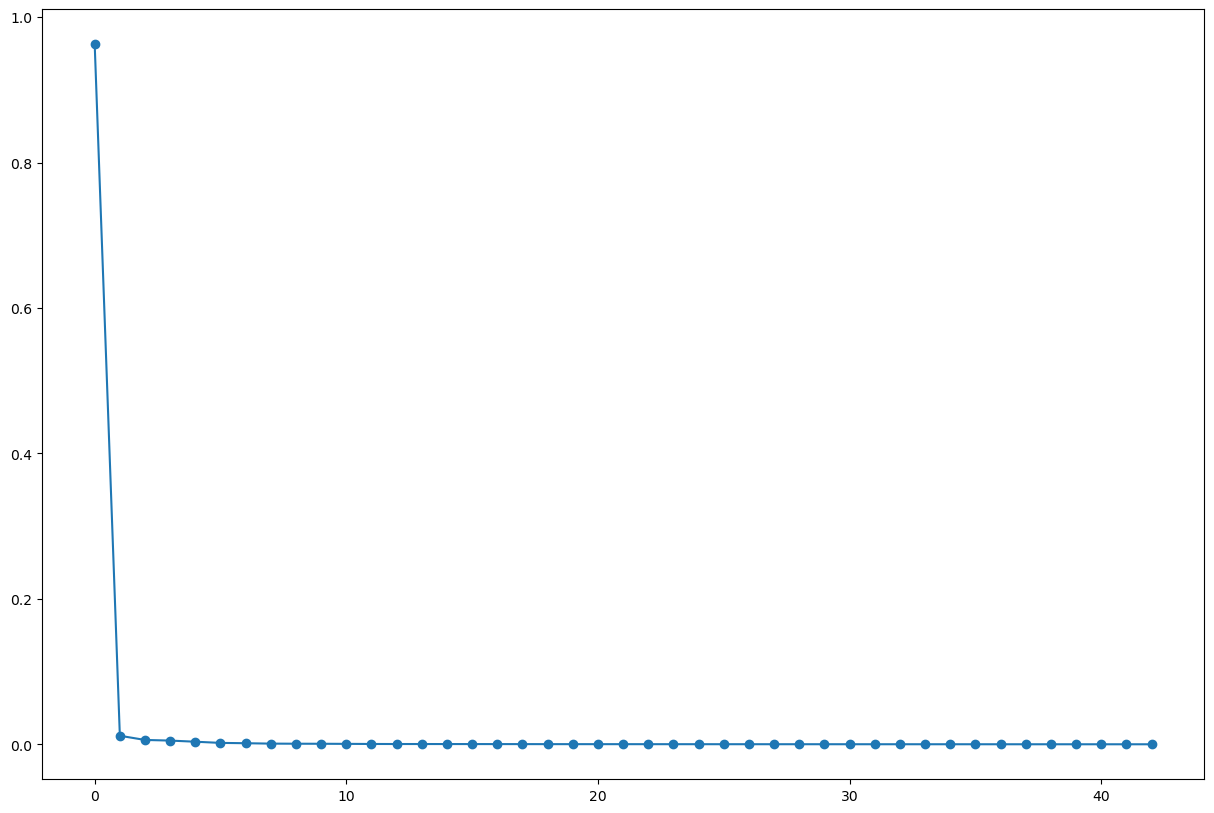

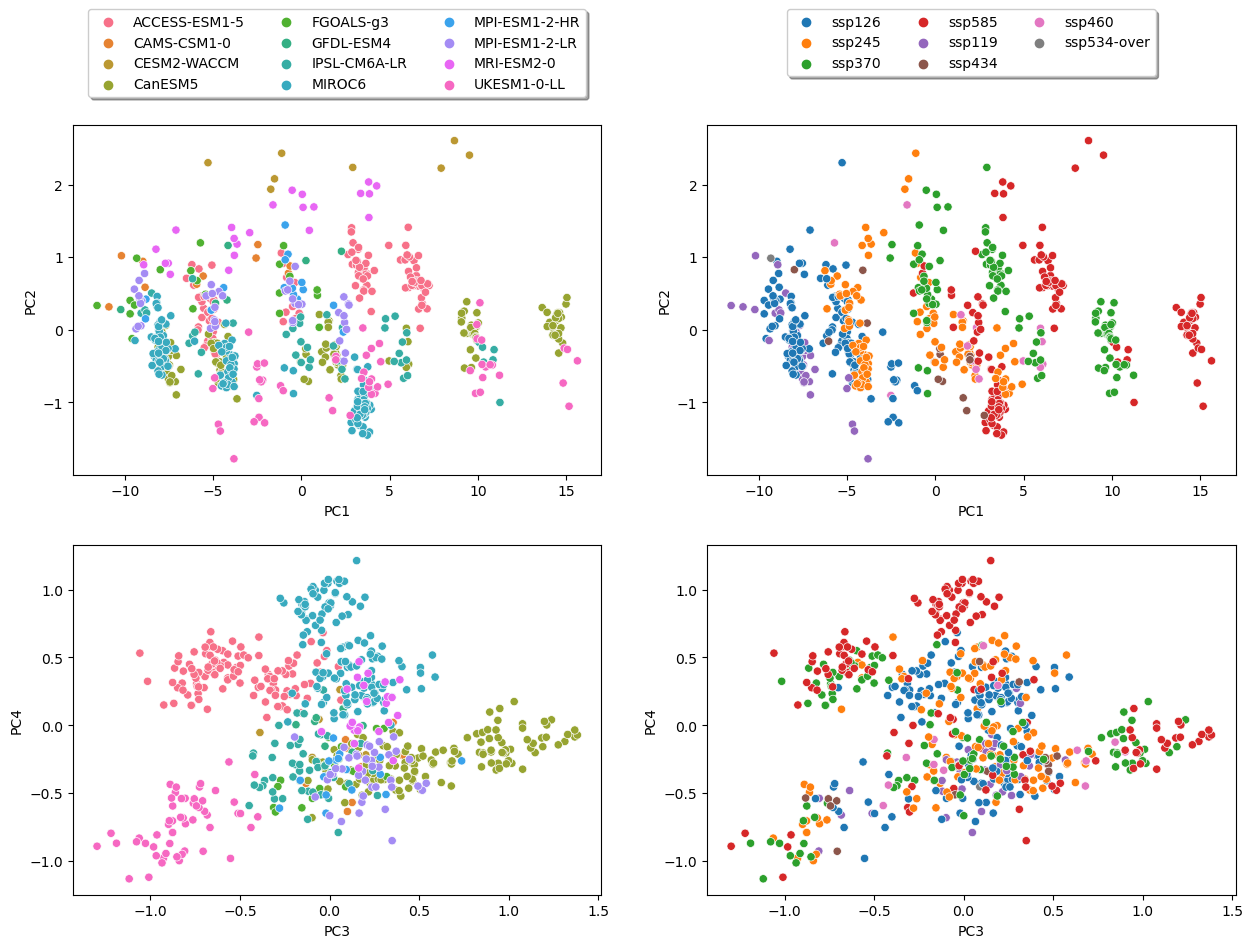

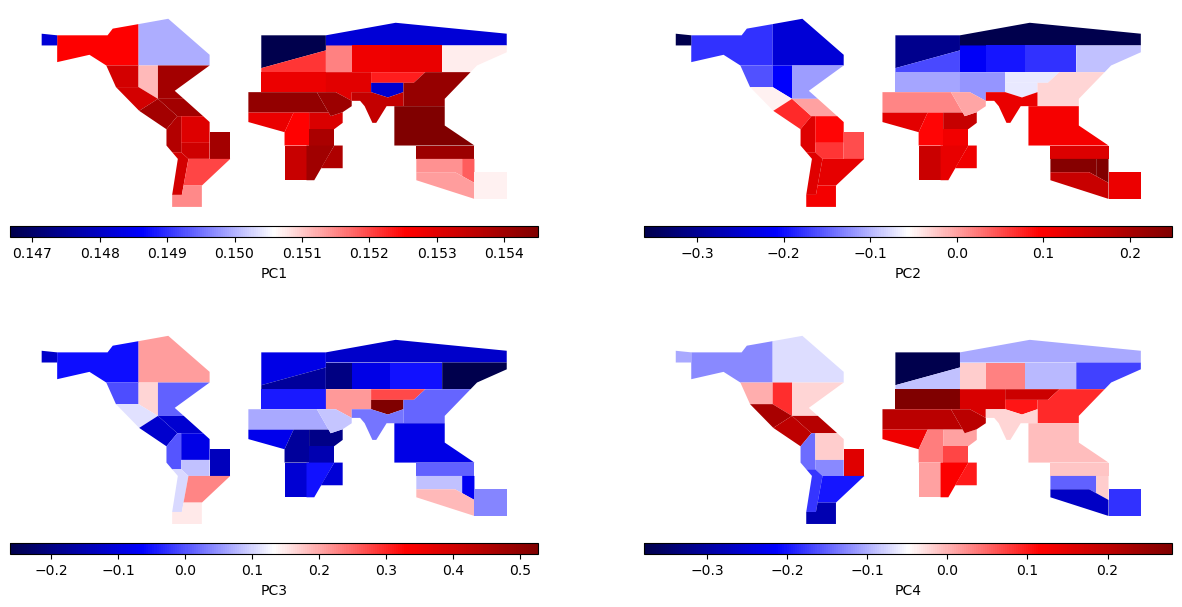

In [78]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_tas_*_timeseries_1980_2099.csv'))]
data, fig1, fig2, fig3 = generalized_pca(files, data_dir, 'tas', True, np.mean)

In [79]:
data

,esm,ensemble,acronym,experiment,variable,year,summary_value
0,ACCESS-ESM1-5,r10i1p1f1,ARP,ssp126,tas,"[2075-01-01, 2095-01-01)",2.200130
1,ACCESS-ESM1-5,r10i1p1f1,ARP,ssp585,tas,"[2075-01-01, 2095-01-01)",5.168463
2,ACCESS-ESM1-5,r10i1p1f1,CAF,ssp126,tas,"[2075-01-01, 2095-01-01)",1.605055
3,ACCESS-ESM1-5,r10i1p1f1,CAF,ssp585,tas,"[2075-01-01, 2095-01-01)",4.145225
4,ACCESS-ESM1-5,r10i1p1f1,CAR,ssp126,tas,"[2075-01-01, 2095-01-01)",1.248377
...,...,...,...,...,...,...,...
27515,UKESM1-0-LL,r9i1p1f2,WSAF,ssp245,tas,"[2075-01-01, 2095-01-01)",3.485379
27516,UKESM1-0-LL,r9i1p1f2,WSAF,ssp370,tas,"[2075-01-01, 2095-01-01)",4.713365
27517,UKESM1-0-LL,r9i1p1f2,WSB,ssp126,tas,"[2075-01-01, 2095-01-01)",4.072419
27518,UKESM1-0-LL,r9i1p1f2,WSB,ssp245,tas,"[2075-01-01, 2095-01-01)",5.658540


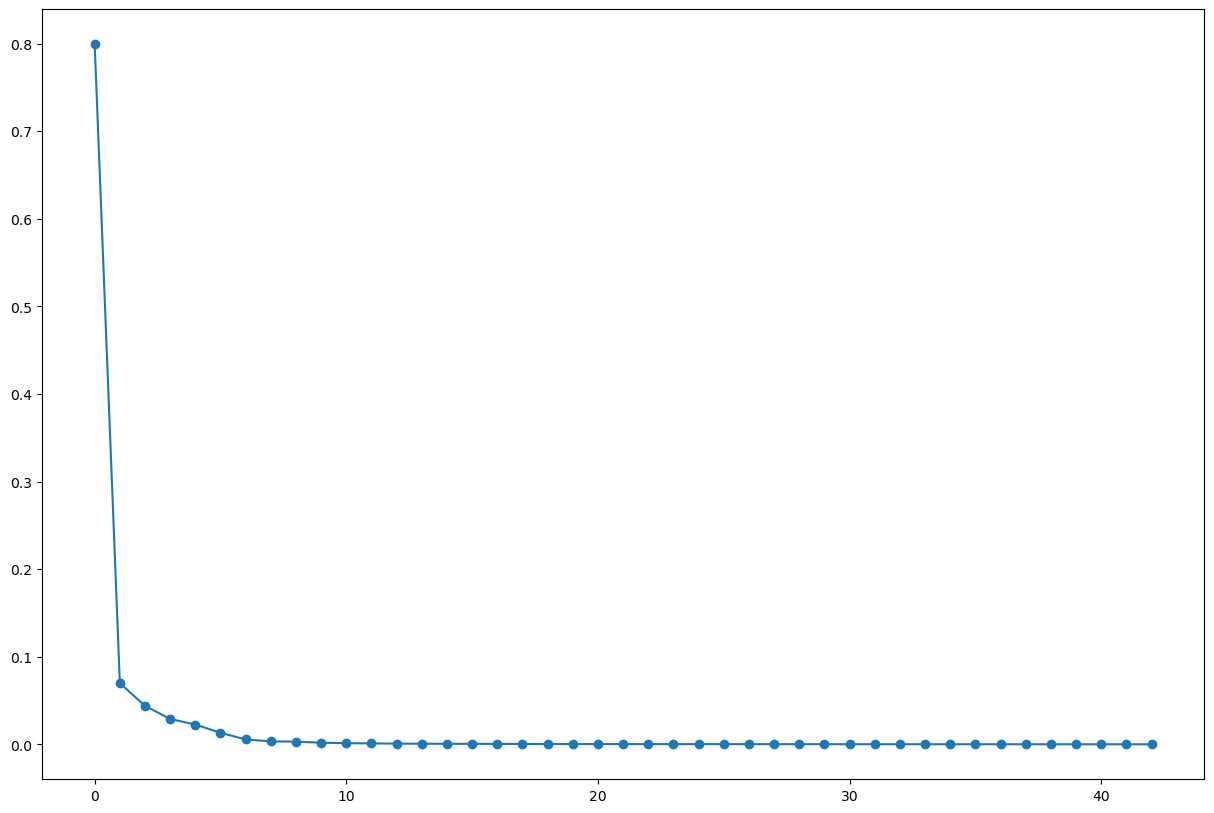

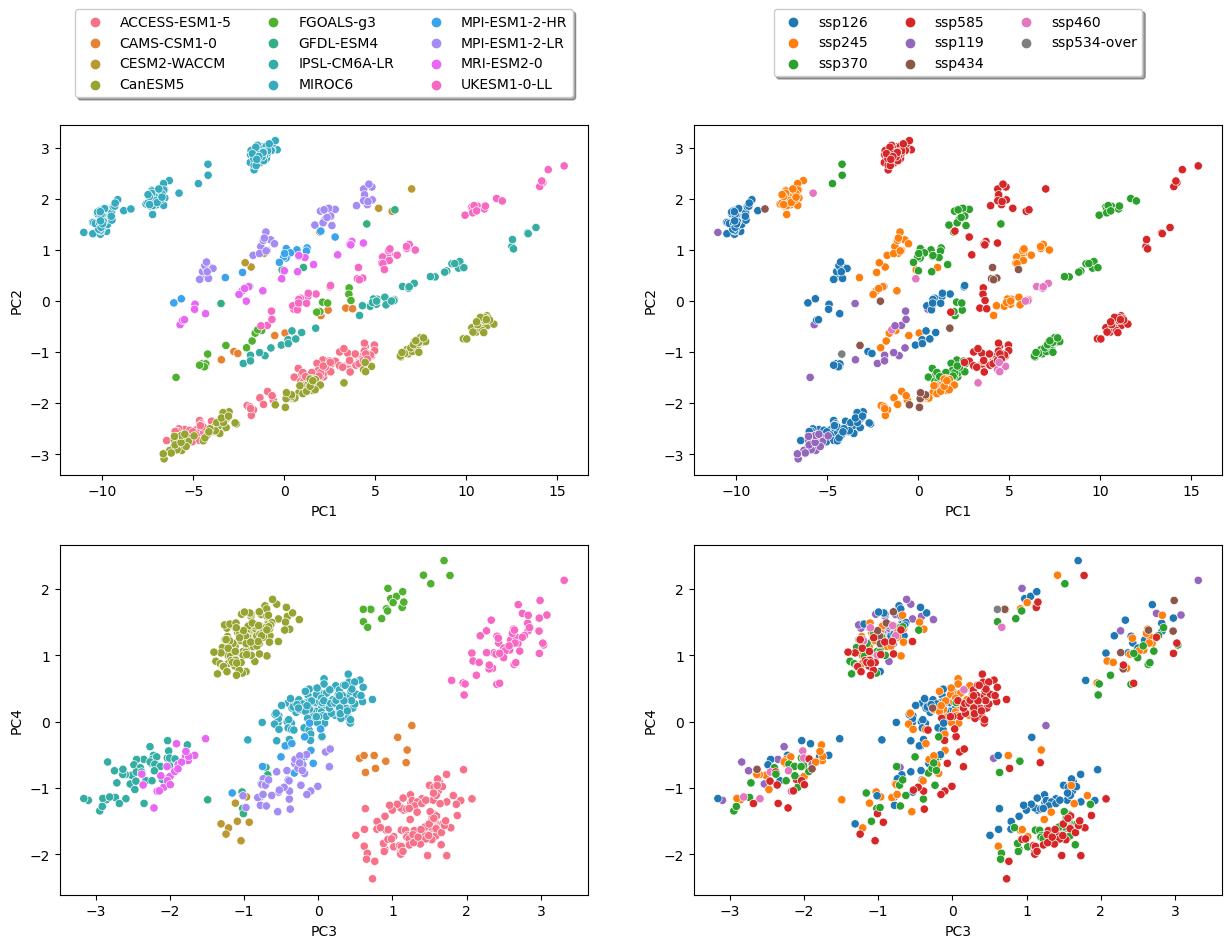

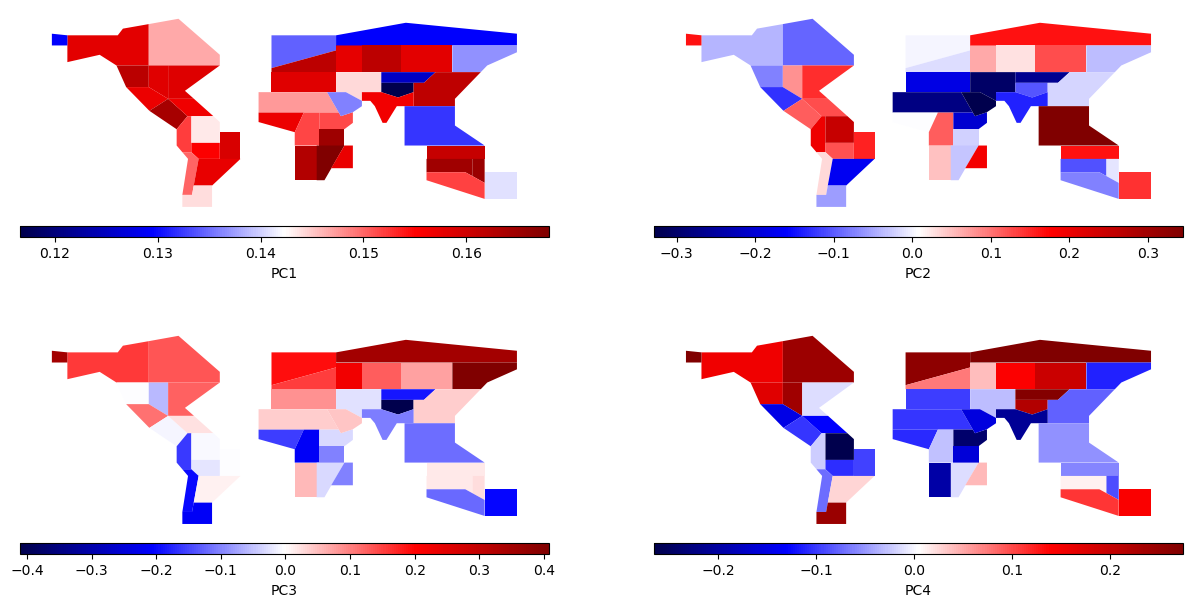

In [80]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_tas_*_timeseries_1980_2099.csv'))]
data, fig1, fig2, fig3 = generalized_pca(files, data_dir, 'tas', True, np.mean)

# "Heatwave" PCA

Truly does not work. Doesn't really make sense, just wanted to try. Possibly reasonable with daily data. Same goes for next section.

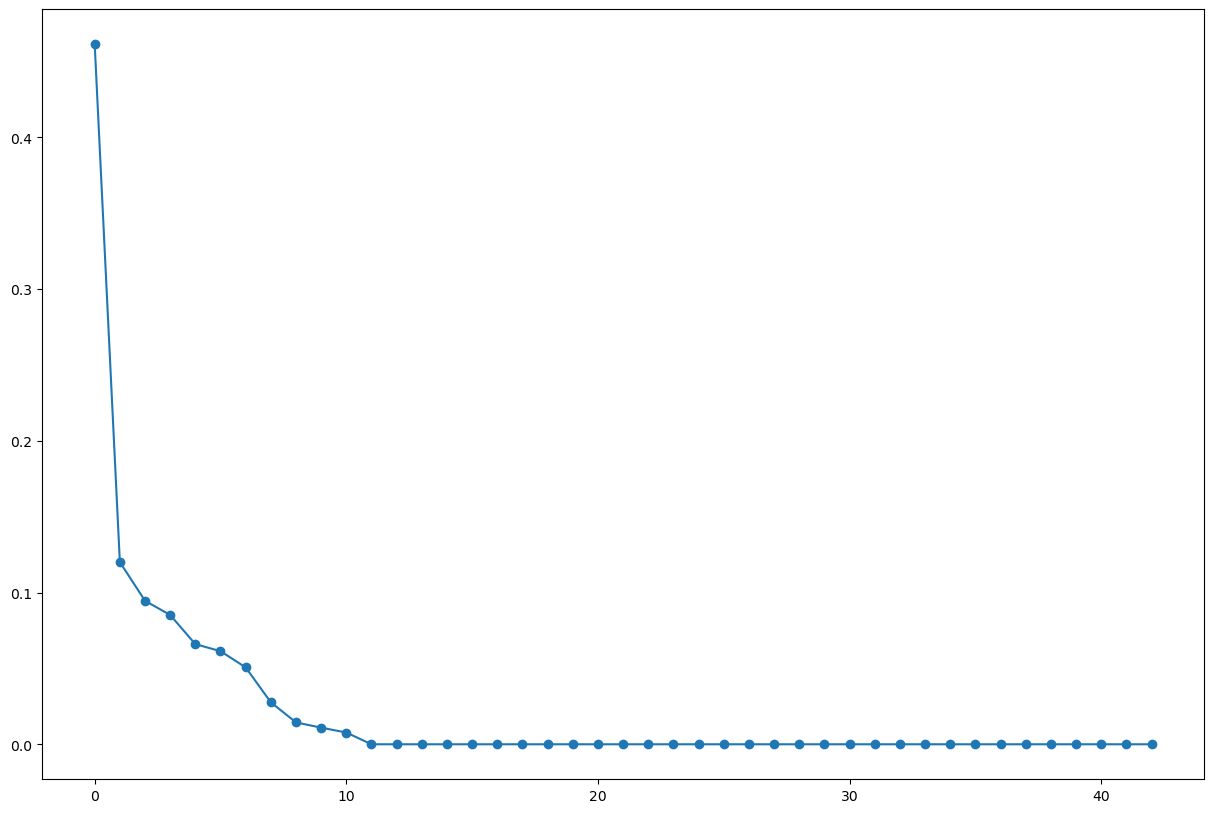

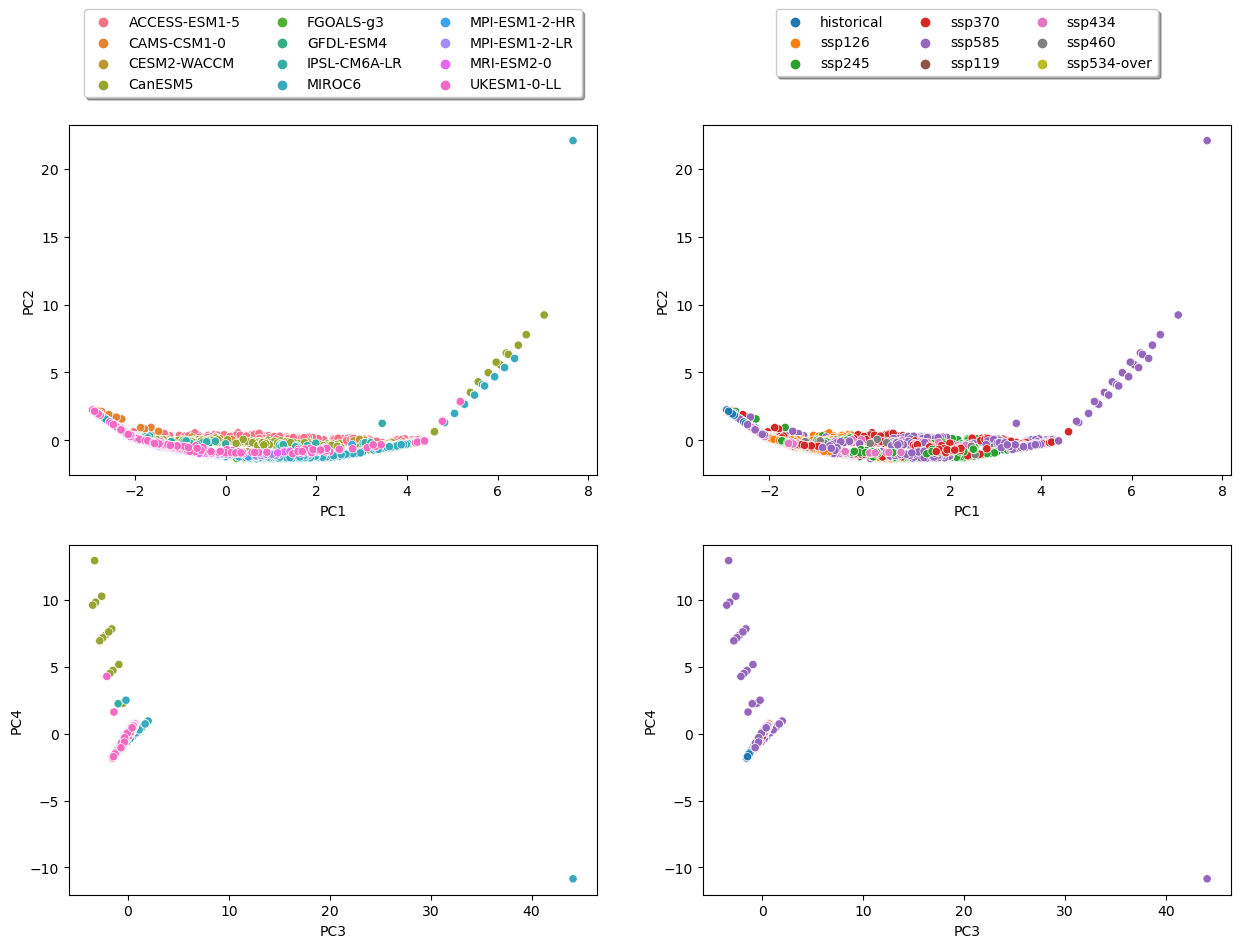

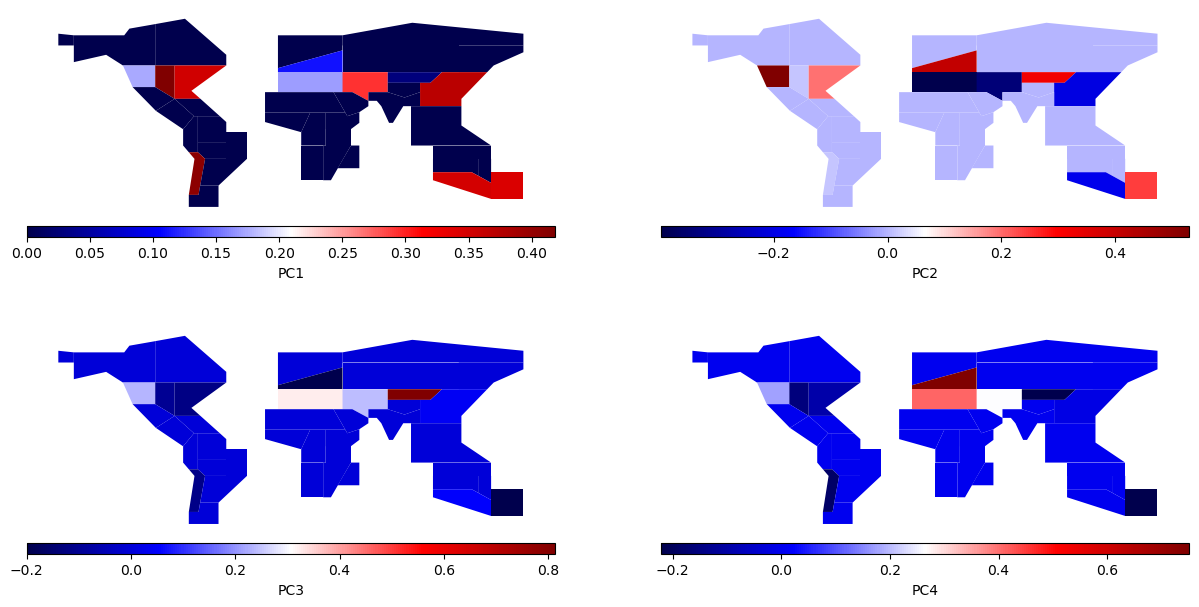

In [45]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_tas_*_timeseries_1980_2099.csv'))]
data, fig1, fig2, fig3 = generalized_pca(files, data_dir, 'tas', True, months_above_thresh)

# "Drought" PCA

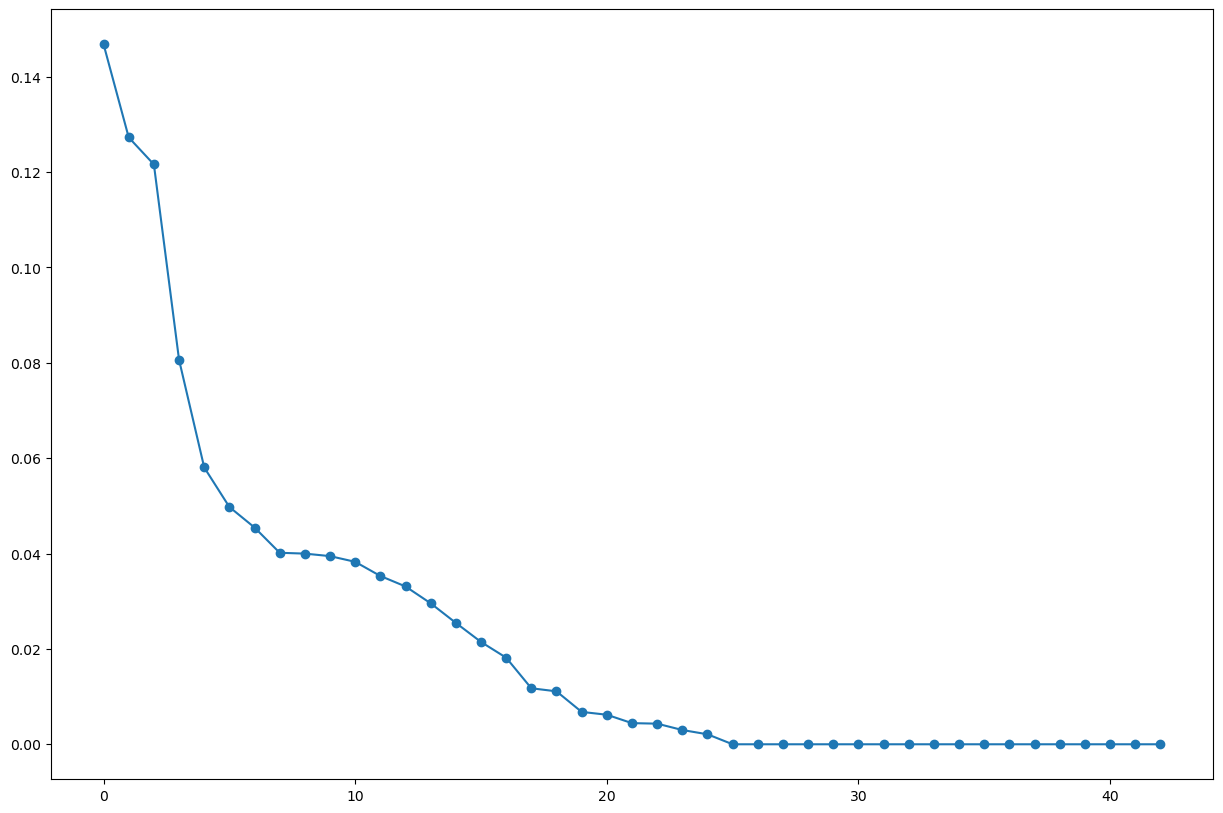

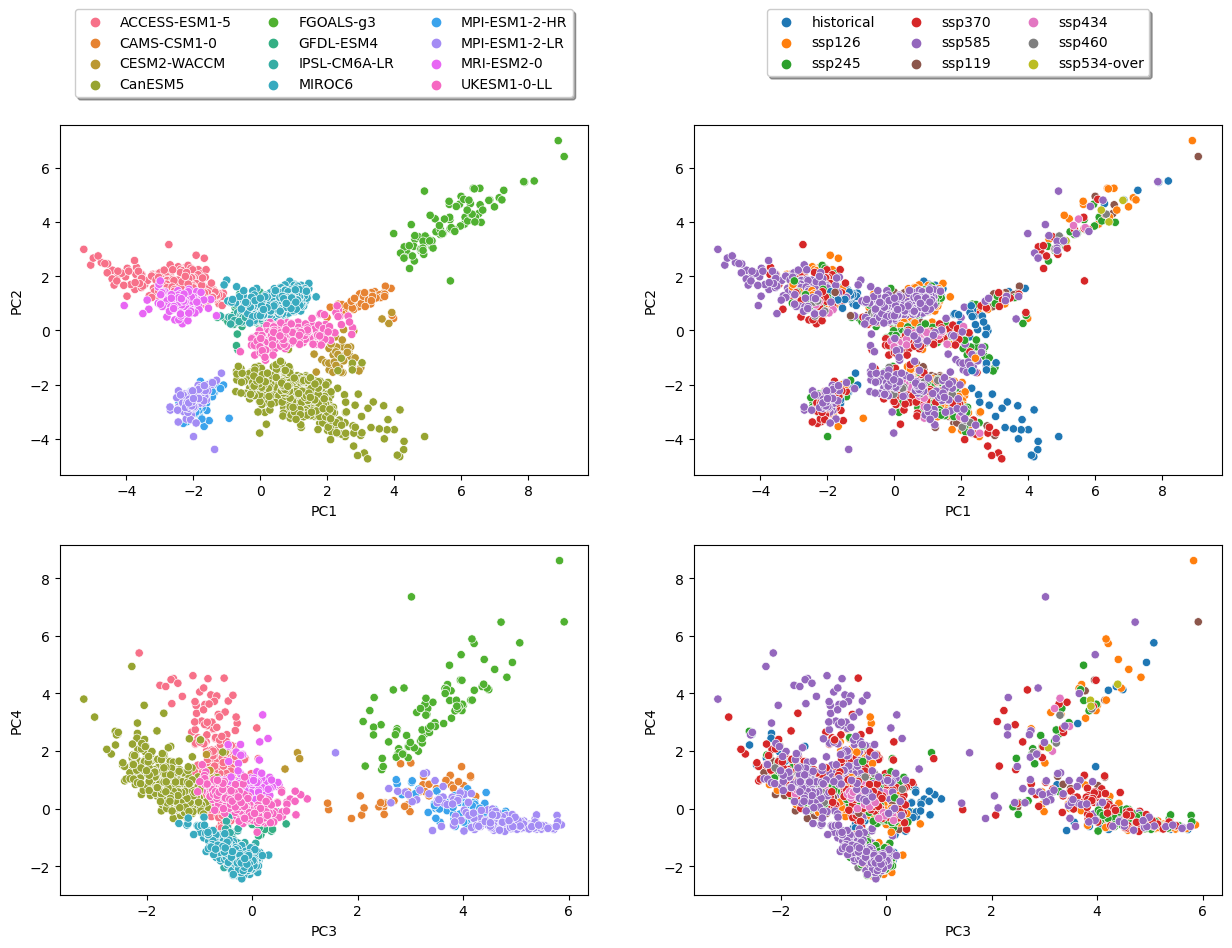

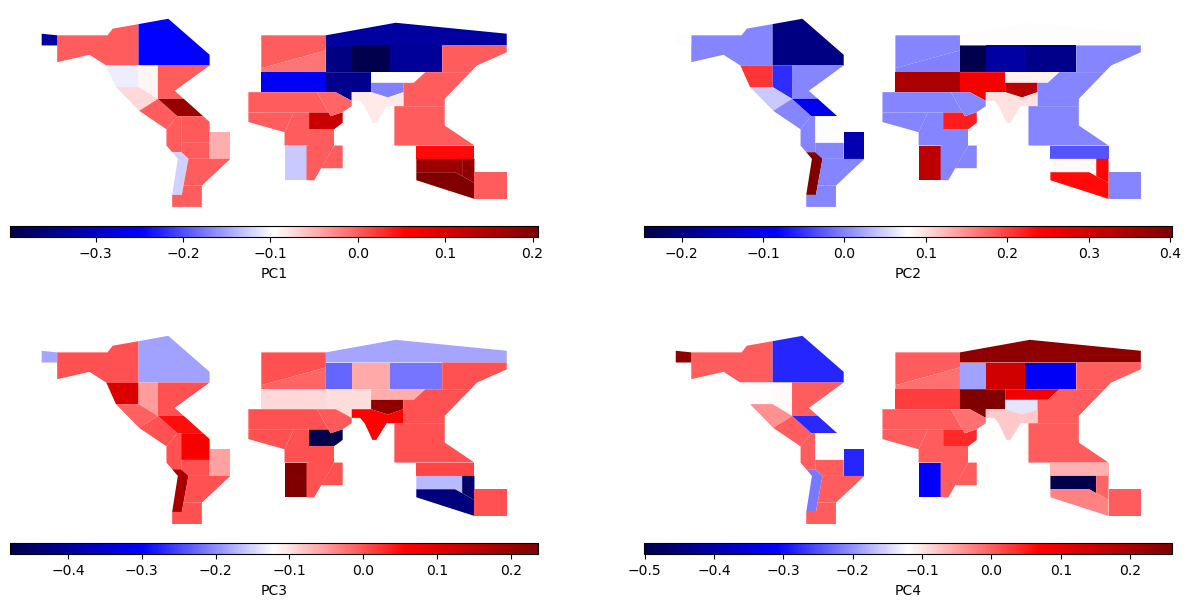

In [46]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_pr_*_timeseries_1980_2099.csv'))]
data, fig1, fig2, fig3 = generalized_pca(files, data_dir, 'pr', True, months_above_thresh, **{'thresh':0.0000157})